# Deep Q-Learning 

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [1]:
import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from agent import *
from model import *
from config import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Understanding the environment

In the following cell, we initialise our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In [2]:
env = gym.make('BreakoutDeterministic-v4')
env.render()

True

In [3]:
number_lives = find_max_lifes(env)
state_size = env.observation_space.shape
action_size = 3
rewards, episodes = [], []

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. 

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [4]:
agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0


### Main Training Loop

/home/sigai/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


episode: 0   score: 1.0   memory length: 160   epsilon: 1.0    steps: 160     evaluation reward: 1.0
episode: 1   score: 2.0   memory length: 377   epsilon: 1.0    steps: 217     evaluation reward: 1.5
episode: 2   score: 2.0   memory length: 594   epsilon: 1.0    steps: 217     evaluation reward: 1.6666666666666667
episode: 3   score: 2.0   memory length: 799   epsilon: 1.0    steps: 205     evaluation reward: 1.75
episode: 4   score: 2.0   memory length: 1001   epsilon: 1.0    steps: 202     evaluation reward: 1.8
episode: 5   score: 0.0   memory length: 1125   epsilon: 1.0    steps: 124     evaluation reward: 1.5
episode: 6   score: 0.0   memory length: 1261   epsilon: 1.0    steps: 136     evaluation reward: 1.2857142857142858
episode: 7   score: 2.0   memory length: 1464   epsilon: 1.0    steps: 203     evaluation reward: 1.375
episode: 8   score: 0.0   memory length: 1599   epsilon: 1.0    steps: 135     evaluation reward: 1.2222222222222223
episode: 9   score: 4.0   memory lengt

episode: 72   score: 0.0   memory length: 12995   epsilon: 1.0    steps: 130     evaluation reward: 1.2054794520547945
episode: 73   score: 2.0   memory length: 13206   epsilon: 1.0    steps: 211     evaluation reward: 1.2162162162162162
episode: 74   score: 1.0   memory length: 13378   epsilon: 1.0    steps: 172     evaluation reward: 1.2133333333333334
episode: 75   score: 1.0   memory length: 13532   epsilon: 1.0    steps: 154     evaluation reward: 1.2105263157894737
episode: 76   score: 1.0   memory length: 13694   epsilon: 1.0    steps: 162     evaluation reward: 1.2077922077922079
episode: 77   score: 0.0   memory length: 13826   epsilon: 1.0    steps: 132     evaluation reward: 1.1923076923076923
episode: 78   score: 3.0   memory length: 14057   epsilon: 1.0    steps: 231     evaluation reward: 1.2151898734177216
episode: 79   score: 3.0   memory length: 14333   epsilon: 1.0    steps: 276     evaluation reward: 1.2375
episode: 80   score: 2.0   memory length: 14556   epsilon: 1

episode: 147   score: 0.0   memory length: 26653   epsilon: 1.0    steps: 139     evaluation reward: 1.28
episode: 148   score: 2.0   memory length: 26869   epsilon: 1.0    steps: 216     evaluation reward: 1.27
episode: 149   score: 4.0   memory length: 27147   epsilon: 1.0    steps: 278     evaluation reward: 1.3
episode: 150   score: 1.0   memory length: 27331   epsilon: 1.0    steps: 184     evaluation reward: 1.3
episode: 151   score: 1.0   memory length: 27503   epsilon: 1.0    steps: 172     evaluation reward: 1.31
episode: 152   score: 3.0   memory length: 27733   epsilon: 1.0    steps: 230     evaluation reward: 1.34
episode: 153   score: 1.0   memory length: 27904   epsilon: 1.0    steps: 171     evaluation reward: 1.34
episode: 154   score: 2.0   memory length: 28125   epsilon: 1.0    steps: 221     evaluation reward: 1.36
episode: 155   score: 1.0   memory length: 28287   epsilon: 1.0    steps: 162     evaluation reward: 1.35
episode: 156   score: 1.0   memory length: 28443

episode: 225   score: 0.0   memory length: 40833   epsilon: 1.0    steps: 138     evaluation reward: 1.26
episode: 226   score: 1.0   memory length: 41006   epsilon: 1.0    steps: 173     evaluation reward: 1.26
episode: 227   score: 1.0   memory length: 41185   epsilon: 1.0    steps: 179     evaluation reward: 1.24
episode: 228   score: 4.0   memory length: 41454   epsilon: 1.0    steps: 269     evaluation reward: 1.26
episode: 229   score: 2.0   memory length: 41652   epsilon: 1.0    steps: 198     evaluation reward: 1.28
episode: 230   score: 4.0   memory length: 41956   epsilon: 1.0    steps: 304     evaluation reward: 1.31
episode: 231   score: 1.0   memory length: 42131   epsilon: 1.0    steps: 175     evaluation reward: 1.32
episode: 232   score: 0.0   memory length: 42260   epsilon: 1.0    steps: 129     evaluation reward: 1.32
episode: 233   score: 0.0   memory length: 42386   epsilon: 1.0    steps: 126     evaluation reward: 1.29
episode: 234   score: 0.0   memory length: 425

episode: 302   score: 2.0   memory length: 55008   epsilon: 1.0    steps: 205     evaluation reward: 1.34
episode: 303   score: 4.0   memory length: 55290   epsilon: 1.0    steps: 282     evaluation reward: 1.37
episode: 304   score: 0.0   memory length: 55415   epsilon: 1.0    steps: 125     evaluation reward: 1.36
episode: 305   score: 2.0   memory length: 55619   epsilon: 1.0    steps: 204     evaluation reward: 1.37
episode: 306   score: 1.0   memory length: 55782   epsilon: 1.0    steps: 163     evaluation reward: 1.35
episode: 307   score: 1.0   memory length: 55956   epsilon: 1.0    steps: 174     evaluation reward: 1.34
episode: 308   score: 0.0   memory length: 56088   epsilon: 1.0    steps: 132     evaluation reward: 1.33
episode: 309   score: 2.0   memory length: 56284   epsilon: 1.0    steps: 196     evaluation reward: 1.33
episode: 310   score: 4.0   memory length: 56564   epsilon: 1.0    steps: 280     evaluation reward: 1.37
episode: 311   score: 5.0   memory length: 568

episode: 380   score: 2.0   memory length: 68811   epsilon: 1.0    steps: 182     evaluation reward: 1.22
episode: 381   score: 1.0   memory length: 68966   epsilon: 1.0    steps: 155     evaluation reward: 1.22
episode: 382   score: 0.0   memory length: 69101   epsilon: 1.0    steps: 135     evaluation reward: 1.21
episode: 383   score: 1.0   memory length: 69260   epsilon: 1.0    steps: 159     evaluation reward: 1.2
episode: 384   score: 3.0   memory length: 69498   epsilon: 1.0    steps: 238     evaluation reward: 1.22
episode: 385   score: 2.0   memory length: 69701   epsilon: 1.0    steps: 203     evaluation reward: 1.22
episode: 386   score: 0.0   memory length: 69837   epsilon: 1.0    steps: 136     evaluation reward: 1.22
episode: 387   score: 3.0   memory length: 70096   epsilon: 1.0    steps: 259     evaluation reward: 1.24
episode: 388   score: 0.0   memory length: 70222   epsilon: 1.0    steps: 126     evaluation reward: 1.24
episode: 389   score: 3.0   memory length: 7045

episode: 458   score: 3.0   memory length: 82906   epsilon: 1.0    steps: 217     evaluation reward: 1.3
episode: 459   score: 1.0   memory length: 83072   epsilon: 1.0    steps: 166     evaluation reward: 1.29
episode: 460   score: 2.0   memory length: 83258   epsilon: 1.0    steps: 186     evaluation reward: 1.3
episode: 461   score: 1.0   memory length: 83416   epsilon: 1.0    steps: 158     evaluation reward: 1.3
episode: 462   score: 2.0   memory length: 83619   epsilon: 1.0    steps: 203     evaluation reward: 1.31
episode: 463   score: 3.0   memory length: 83849   epsilon: 1.0    steps: 230     evaluation reward: 1.33
episode: 464   score: 2.0   memory length: 84055   epsilon: 1.0    steps: 206     evaluation reward: 1.34
episode: 465   score: 1.0   memory length: 84224   epsilon: 1.0    steps: 169     evaluation reward: 1.34
episode: 466   score: 0.0   memory length: 84350   epsilon: 1.0    steps: 126     evaluation reward: 1.32
episode: 467   score: 2.0   memory length: 84571 

episode: 536   score: 2.0   memory length: 96450   epsilon: 1.0    steps: 205     evaluation reward: 1.14
episode: 537   score: 0.0   memory length: 96577   epsilon: 1.0    steps: 127     evaluation reward: 1.11
episode: 538   score: 1.0   memory length: 96732   epsilon: 1.0    steps: 155     evaluation reward: 1.11
episode: 539   score: 2.0   memory length: 96935   epsilon: 1.0    steps: 203     evaluation reward: 1.13
episode: 540   score: 0.0   memory length: 97061   epsilon: 1.0    steps: 126     evaluation reward: 1.11
episode: 541   score: 0.0   memory length: 97187   epsilon: 1.0    steps: 126     evaluation reward: 1.09
episode: 542   score: 4.0   memory length: 97469   epsilon: 1.0    steps: 282     evaluation reward: 1.12
episode: 543   score: 2.0   memory length: 97672   epsilon: 1.0    steps: 203     evaluation reward: 1.13
episode: 544   score: 1.0   memory length: 97841   epsilon: 1.0    steps: 169     evaluation reward: 1.14
episode: 545   score: 0.0   memory length: 979

episode: 606   score: 3.0   memory length: 109005   epsilon: 0.9914443000000039    steps: 220     evaluation reward: 1.17
episode: 607   score: 1.0   memory length: 109172   epsilon: 0.991285650000004    steps: 167     evaluation reward: 1.17
episode: 608   score: 1.0   memory length: 109345   epsilon: 0.9911213000000041    steps: 173     evaluation reward: 1.17
episode: 609   score: 0.0   memory length: 109472   epsilon: 0.9910006500000041    steps: 127     evaluation reward: 1.17
episode: 610   score: 1.0   memory length: 109644   epsilon: 0.9908372500000042    steps: 172     evaluation reward: 1.14
episode: 611   score: 0.0   memory length: 109780   epsilon: 0.9907080500000043    steps: 136     evaluation reward: 1.14
episode: 612   score: 1.0   memory length: 109935   epsilon: 0.9905608000000043    steps: 155     evaluation reward: 1.15
episode: 613   score: 2.0   memory length: 110149   epsilon: 0.9903575000000044    steps: 214     evaluation reward: 1.17
episode: 614   score: 1.0

episode: 674   score: 1.0   memory length: 121267   epsilon: 0.9797954000000093    steps: 185     evaluation reward: 1.31
episode: 675   score: 1.0   memory length: 121426   epsilon: 0.9796443500000094    steps: 159     evaluation reward: 1.3
episode: 676   score: 0.0   memory length: 121562   epsilon: 0.9795151500000094    steps: 136     evaluation reward: 1.29
episode: 677   score: 2.0   memory length: 121750   epsilon: 0.9793365500000095    steps: 188     evaluation reward: 1.3
episode: 678   score: 0.0   memory length: 121876   epsilon: 0.9792168500000096    steps: 126     evaluation reward: 1.29
episode: 679   score: 5.0   memory length: 122200   epsilon: 0.9789090500000097    steps: 324     evaluation reward: 1.33
episode: 680   score: 0.0   memory length: 122330   epsilon: 0.9787855500000098    steps: 130     evaluation reward: 1.31
episode: 681   score: 2.0   memory length: 122544   epsilon: 0.9785822500000099    steps: 214     evaluation reward: 1.33
episode: 682   score: 0.0 

episode: 742   score: 0.0   memory length: 132812   epsilon: 0.9688276500000144    steps: 152     evaluation reward: 1.03
episode: 743   score: 0.0   memory length: 132939   epsilon: 0.9687070000000144    steps: 127     evaluation reward: 1.02
episode: 744   score: 2.0   memory length: 133163   epsilon: 0.9684942000000145    steps: 224     evaluation reward: 1.02
episode: 745   score: 2.0   memory length: 133368   epsilon: 0.9682994500000146    steps: 205     evaluation reward: 1.01
episode: 746   score: 3.0   memory length: 133608   epsilon: 0.9680714500000147    steps: 240     evaluation reward: 1.04
episode: 747   score: 2.0   memory length: 133820   epsilon: 0.9678700500000148    steps: 212     evaluation reward: 1.06
episode: 748   score: 2.0   memory length: 134013   epsilon: 0.9676867000000149    steps: 193     evaluation reward: 1.08
episode: 749   score: 0.0   memory length: 134142   epsilon: 0.9675641500000149    steps: 129     evaluation reward: 1.06
episode: 750   score: 2.

episode: 810   score: 3.0   memory length: 144874   epsilon: 0.9573687500000196    steps: 228     evaluation reward: 1.23
episode: 811   score: 1.0   memory length: 145031   epsilon: 0.9572196000000197    steps: 157     evaluation reward: 1.22
episode: 812   score: 0.0   memory length: 145166   epsilon: 0.9570913500000198    steps: 135     evaluation reward: 1.21
episode: 813   score: 3.0   memory length: 145382   epsilon: 0.9568861500000199    steps: 216     evaluation reward: 1.23
episode: 814   score: 2.0   memory length: 145571   epsilon: 0.95670660000002    steps: 189     evaluation reward: 1.22
episode: 815   score: 2.0   memory length: 145785   epsilon: 0.95650330000002    steps: 214     evaluation reward: 1.24
episode: 816   score: 4.0   memory length: 146082   epsilon: 0.9562211500000202    steps: 297     evaluation reward: 1.28
episode: 817   score: 1.0   memory length: 146234   epsilon: 0.9560767500000202    steps: 152     evaluation reward: 1.28
episode: 818   score: 1.0   

episode: 877   score: 0.0   memory length: 157679   epsilon: 0.9452040000000252    steps: 126     evaluation reward: 1.55
episode: 878   score: 1.0   memory length: 157846   epsilon: 0.9450453500000253    steps: 167     evaluation reward: 1.55
episode: 879   score: 1.0   memory length: 158027   epsilon: 0.9448734000000254    steps: 181     evaluation reward: 1.54
episode: 880   score: 1.0   memory length: 158188   epsilon: 0.9447204500000255    steps: 161     evaluation reward: 1.53
episode: 881   score: 4.0   memory length: 158490   epsilon: 0.9444335500000256    steps: 302     evaluation reward: 1.55
episode: 882   score: 3.0   memory length: 158739   epsilon: 0.9441970000000257    steps: 249     evaluation reward: 1.58
episode: 883   score: 1.0   memory length: 158910   epsilon: 0.9440345500000258    steps: 171     evaluation reward: 1.58
episode: 884   score: 1.0   memory length: 159069   epsilon: 0.9438835000000259    steps: 159     evaluation reward: 1.59
episode: 885   score: 1.

episode: 945   score: 1.0   memory length: 171488   epsilon: 0.9320854500000313    steps: 158     evaluation reward: 1.77
episode: 946   score: 0.0   memory length: 171619   epsilon: 0.9319610000000313    steps: 131     evaluation reward: 1.75
episode: 947   score: 2.0   memory length: 171819   epsilon: 0.9317710000000314    steps: 200     evaluation reward: 1.75
episode: 948   score: 0.0   memory length: 171954   epsilon: 0.9316427500000315    steps: 135     evaluation reward: 1.75
episode: 949   score: 0.0   memory length: 172094   epsilon: 0.9315097500000316    steps: 140     evaluation reward: 1.71
episode: 950   score: 1.0   memory length: 172246   epsilon: 0.9313653500000316    steps: 152     evaluation reward: 1.68
episode: 951   score: 1.0   memory length: 172405   epsilon: 0.9312143000000317    steps: 159     evaluation reward: 1.69
episode: 952   score: 1.0   memory length: 172559   epsilon: 0.9310680000000318    steps: 154     evaluation reward: 1.68
episode: 953   score: 3.

episode: 1013   score: 0.0   memory length: 184357   epsilon: 0.9198599000000369    steps: 127     evaluation reward: 1.62
episode: 1014   score: 5.0   memory length: 184662   epsilon: 0.9195701500000371    steps: 305     evaluation reward: 1.67
episode: 1015   score: 2.0   memory length: 184876   epsilon: 0.9193668500000372    steps: 214     evaluation reward: 1.68
episode: 1016   score: 6.0   memory length: 185224   epsilon: 0.9190362500000373    steps: 348     evaluation reward: 1.69
episode: 1017   score: 1.0   memory length: 185384   epsilon: 0.9188842500000374    steps: 160     evaluation reward: 1.67
episode: 1018   score: 2.0   memory length: 185587   epsilon: 0.9186914000000375    steps: 203     evaluation reward: 1.67
episode: 1019   score: 0.0   memory length: 185714   epsilon: 0.9185707500000375    steps: 127     evaluation reward: 1.64
episode: 1020   score: 1.0   memory length: 185890   epsilon: 0.9184035500000376    steps: 176     evaluation reward: 1.65
episode: 1021   

episode: 1080   score: 1.0   memory length: 197614   epsilon: 0.9072657500000427    steps: 171     evaluation reward: 1.75
episode: 1081   score: 3.0   memory length: 197866   epsilon: 0.9070263500000428    steps: 252     evaluation reward: 1.76
episode: 1082   score: 2.0   memory length: 198087   epsilon: 0.9068164000000429    steps: 221     evaluation reward: 1.78
episode: 1083   score: 0.0   memory length: 198222   epsilon: 0.906688150000043    steps: 135     evaluation reward: 1.78
episode: 1084   score: 1.0   memory length: 198373   epsilon: 0.9065447000000431    steps: 151     evaluation reward: 1.79
episode: 1085   score: 3.0   memory length: 198630   epsilon: 0.9063005500000432    steps: 257     evaluation reward: 1.81
episode: 1086   score: 4.0   memory length: 198908   epsilon: 0.9060364500000433    steps: 278     evaluation reward: 1.85
episode: 1087   score: 2.0   memory length: 199094   epsilon: 0.9058597500000434    steps: 186     evaluation reward: 1.84
episode: 1088   s

episode: 1147   score: 0.0   memory length: 211198   epsilon: 0.8943609500000487    steps: 134     evaluation reward: 1.92
episode: 1148   score: 3.0   memory length: 211430   epsilon: 0.8941405500000488    steps: 232     evaluation reward: 1.93
episode: 1149   score: 2.0   memory length: 211623   epsilon: 0.8939572000000489    steps: 193     evaluation reward: 1.94
episode: 1150   score: 0.0   memory length: 211750   epsilon: 0.8938365500000489    steps: 127     evaluation reward: 1.94
episode: 1151   score: 5.0   memory length: 212065   epsilon: 0.893537300000049    steps: 315     evaluation reward: 1.97
episode: 1152   score: 4.0   memory length: 212323   epsilon: 0.8932922000000492    steps: 258     evaluation reward: 2.0
episode: 1153   score: 3.0   memory length: 212544   epsilon: 0.8930822500000493    steps: 221     evaluation reward: 2.03
episode: 1154   score: 3.0   memory length: 212761   epsilon: 0.8928761000000494    steps: 217     evaluation reward: 2.03
episode: 1155   sc

episode: 1214   score: 0.0   memory length: 225401   epsilon: 0.8808681000000549    steps: 132     evaluation reward: 2.0
episode: 1215   score: 4.0   memory length: 225652   epsilon: 0.880629650000055    steps: 251     evaluation reward: 2.02
episode: 1216   score: 2.0   memory length: 225862   epsilon: 0.8804301500000551    steps: 210     evaluation reward: 2.03
episode: 1217   score: 0.0   memory length: 226006   epsilon: 0.8802933500000552    steps: 144     evaluation reward: 1.99
episode: 1218   score: 1.0   memory length: 226164   epsilon: 0.8801432500000552    steps: 158     evaluation reward: 1.99
episode: 1219   score: 5.0   memory length: 226497   epsilon: 0.8798269000000554    steps: 333     evaluation reward: 2.02
episode: 1220   score: 4.0   memory length: 226790   epsilon: 0.8795485500000555    steps: 293     evaluation reward: 2.02
episode: 1221   score: 4.0   memory length: 227093   epsilon: 0.8792607000000556    steps: 303     evaluation reward: 2.02
episode: 1222   sc

episode: 1281   score: 0.0   memory length: 240444   epsilon: 0.8665772500000615    steps: 129     evaluation reward: 2.4
episode: 1282   score: 3.0   memory length: 240708   epsilon: 0.8663264500000616    steps: 264     evaluation reward: 2.41
episode: 1283   score: 7.0   memory length: 240995   epsilon: 0.8660538000000617    steps: 287     evaluation reward: 2.48
episode: 1284   score: 0.0   memory length: 241125   epsilon: 0.8659303000000618    steps: 130     evaluation reward: 2.45
episode: 1285   score: 4.0   memory length: 241385   epsilon: 0.8656833000000619    steps: 260     evaluation reward: 2.48
episode: 1286   score: 2.0   memory length: 241606   epsilon: 0.865473350000062    steps: 221     evaluation reward: 2.49
episode: 1287   score: 3.0   memory length: 241863   epsilon: 0.8652292000000621    steps: 257     evaluation reward: 2.49
episode: 1288   score: 1.0   memory length: 242047   epsilon: 0.8650544000000622    steps: 184     evaluation reward: 2.46
episode: 1289   sc

episode: 1348   score: 1.0   memory length: 254978   epsilon: 0.8527699500000678    steps: 181     evaluation reward: 2.31
episode: 1349   score: 2.0   memory length: 255167   epsilon: 0.8525904000000679    steps: 189     evaluation reward: 2.3
episode: 1350   score: 2.0   memory length: 255351   epsilon: 0.852415600000068    steps: 184     evaluation reward: 2.3
episode: 1351   score: 3.0   memory length: 255621   epsilon: 0.8521591000000681    steps: 270     evaluation reward: 2.3
episode: 1352   score: 6.0   memory length: 255981   epsilon: 0.8518171000000683    steps: 360     evaluation reward: 2.35
episode: 1353   score: 1.0   memory length: 256148   epsilon: 0.8516584500000683    steps: 167     evaluation reward: 2.35
episode: 1354   score: 4.0   memory length: 256412   epsilon: 0.8514076500000685    steps: 264     evaluation reward: 2.35
episode: 1355   score: 2.0   memory length: 256619   epsilon: 0.8512110000000686    steps: 207     evaluation reward: 2.34
episode: 1356   scor

episode: 1415   score: 4.0   memory length: 270052   epsilon: 0.8384496500000744    steps: 277     evaluation reward: 2.4
episode: 1416   score: 0.0   memory length: 270182   epsilon: 0.8383261500000745    steps: 130     evaluation reward: 2.35
episode: 1417   score: 0.0   memory length: 270310   epsilon: 0.8382045500000745    steps: 128     evaluation reward: 2.32
episode: 1418   score: 0.0   memory length: 270441   epsilon: 0.8380801000000746    steps: 131     evaluation reward: 2.32
episode: 1419   score: 3.0   memory length: 270693   epsilon: 0.8378407000000747    steps: 252     evaluation reward: 2.35
episode: 1420   score: 3.0   memory length: 270967   epsilon: 0.8375804000000748    steps: 274     evaluation reward: 2.34
episode: 1421   score: 3.0   memory length: 271223   epsilon: 0.8373372000000749    steps: 256     evaluation reward: 2.36
episode: 1422   score: 8.0   memory length: 271523   epsilon: 0.8370522000000751    steps: 300     evaluation reward: 2.43
episode: 1423   s

episode: 1482   score: 1.0   memory length: 285916   epsilon: 0.8233788500000814    steps: 159     evaluation reward: 2.79
episode: 1483   score: 3.0   memory length: 286153   epsilon: 0.8231537000000815    steps: 237     evaluation reward: 2.81
episode: 1484   score: 4.0   memory length: 286472   epsilon: 0.8228506500000816    steps: 319     evaluation reward: 2.84
episode: 1485   score: 5.0   memory length: 286800   epsilon: 0.8225390500000818    steps: 328     evaluation reward: 2.88
episode: 1486   score: 1.0   memory length: 286957   epsilon: 0.8223899000000818    steps: 157     evaluation reward: 2.85
episode: 1487   score: 3.0   memory length: 287196   epsilon: 0.8221628500000819    steps: 239     evaluation reward: 2.86
episode: 1488   score: 1.0   memory length: 287361   epsilon: 0.822006100000082    steps: 165     evaluation reward: 2.84
episode: 1489   score: 2.0   memory length: 287551   epsilon: 0.8218256000000821    steps: 190     evaluation reward: 2.84
episode: 1490   s

episode: 1549   score: 2.0   memory length: 303304   epsilon: 0.806860250000089    steps: 212     evaluation reward: 3.32
episode: 1550   score: 4.0   memory length: 303598   epsilon: 0.8065809500000891    steps: 294     evaluation reward: 3.34
episode: 1551   score: 1.0   memory length: 303753   epsilon: 0.8064337000000892    steps: 155     evaluation reward: 3.33
episode: 1552   score: 6.0   memory length: 304119   epsilon: 0.8060860000000893    steps: 366     evaluation reward: 3.38
episode: 1553   score: 6.0   memory length: 304498   epsilon: 0.8057259500000895    steps: 379     evaluation reward: 3.4
episode: 1554   score: 5.0   memory length: 304826   epsilon: 0.8054143500000897    steps: 328     evaluation reward: 3.44
episode: 1555   score: 1.0   memory length: 304984   epsilon: 0.8052642500000897    steps: 158     evaluation reward: 3.4
episode: 1556   score: 7.0   memory length: 305388   epsilon: 0.8048804500000899    steps: 404     evaluation reward: 3.45
episode: 1557   sco

episode: 1616   score: 2.0   memory length: 320378   epsilon: 0.7906399500000965    steps: 207     evaluation reward: 3.3
episode: 1617   score: 14.0   memory length: 320798   epsilon: 0.7902409500000966    steps: 420     evaluation reward: 3.42
episode: 1618   score: 6.0   memory length: 321162   epsilon: 0.7898951500000968    steps: 364     evaluation reward: 3.47
episode: 1619   score: 4.0   memory length: 321429   epsilon: 0.7896415000000969    steps: 267     evaluation reward: 3.51
episode: 1620   score: 2.0   memory length: 321638   epsilon: 0.789442950000097    steps: 209     evaluation reward: 3.5
episode: 1621   score: 1.0   memory length: 321797   epsilon: 0.7892919000000971    steps: 159     evaluation reward: 3.5
episode: 1622   score: 4.0   memory length: 322085   epsilon: 0.7890183000000972    steps: 288     evaluation reward: 3.5
episode: 1623   score: 2.0   memory length: 322285   epsilon: 0.7888283000000973    steps: 200     evaluation reward: 3.48
episode: 1624   scor

episode: 1683   score: 3.0   memory length: 337274   epsilon: 0.7745887500001039    steps: 229     evaluation reward: 3.3
episode: 1684   score: 2.0   memory length: 337504   epsilon: 0.774370250000104    steps: 230     evaluation reward: 3.3
episode: 1685   score: 4.0   memory length: 337781   epsilon: 0.7741071000001041    steps: 277     evaluation reward: 3.31
episode: 1686   score: 2.0   memory length: 338007   epsilon: 0.7738924000001042    steps: 226     evaluation reward: 3.29
episode: 1687   score: 2.0   memory length: 338192   epsilon: 0.7737166500001043    steps: 185     evaluation reward: 3.3
episode: 1688   score: 4.0   memory length: 338474   epsilon: 0.7734487500001044    steps: 282     evaluation reward: 3.29
episode: 1689   score: 4.0   memory length: 338749   epsilon: 0.7731875000001045    steps: 275     evaluation reward: 3.3
episode: 1690   score: 4.0   memory length: 339016   epsilon: 0.7729338500001046    steps: 267     evaluation reward: 3.3
episode: 1691   score:

episode: 1750   score: 1.0   memory length: 354747   epsilon: 0.7579894000001115    steps: 157     evaluation reward: 3.29
episode: 1751   score: 3.0   memory length: 354983   epsilon: 0.7577652000001116    steps: 236     evaluation reward: 3.32
episode: 1752   score: 6.0   memory length: 355361   epsilon: 0.7574061000001118    steps: 378     evaluation reward: 3.37
episode: 1753   score: 1.0   memory length: 355529   epsilon: 0.7572465000001118    steps: 168     evaluation reward: 3.35
episode: 1754   score: 5.0   memory length: 355846   epsilon: 0.756945350000112    steps: 317     evaluation reward: 3.38
episode: 1755   score: 5.0   memory length: 356175   epsilon: 0.7566328000001121    steps: 329     evaluation reward: 3.4
episode: 1756   score: 2.0   memory length: 356381   epsilon: 0.7564371000001122    steps: 206     evaluation reward: 3.38
episode: 1757   score: 6.0   memory length: 356749   epsilon: 0.7560875000001124    steps: 368     evaluation reward: 3.41
episode: 1758   sc

episode: 1817   score: 1.0   memory length: 373579   epsilon: 0.7400990000001197    steps: 161     evaluation reward: 3.97
episode: 1818   score: 1.0   memory length: 373742   epsilon: 0.7399441500001198    steps: 163     evaluation reward: 3.96
episode: 1819   score: 2.0   memory length: 373980   epsilon: 0.7397180500001199    steps: 238     evaluation reward: 3.94
episode: 1820   score: 4.0   memory length: 374247   epsilon: 0.73946440000012    steps: 267     evaluation reward: 3.94
episode: 1821   score: 2.0   memory length: 374442   epsilon: 0.7392791500001201    steps: 195     evaluation reward: 3.95
episode: 1822   score: 4.0   memory length: 374742   epsilon: 0.7389941500001203    steps: 300     evaluation reward: 3.94
episode: 1823   score: 6.0   memory length: 375083   epsilon: 0.7386702000001204    steps: 341     evaluation reward: 3.95
episode: 1824   score: 6.0   memory length: 375426   epsilon: 0.7383443500001206    steps: 343     evaluation reward: 3.99
episode: 1825   sc

episode: 1884   score: 6.0   memory length: 393437   epsilon: 0.7212339000001284    steps: 368     evaluation reward: 4.74
episode: 1885   score: 5.0   memory length: 393731   epsilon: 0.7209546000001286    steps: 294     evaluation reward: 4.74
episode: 1886   score: 1.0   memory length: 393883   epsilon: 0.7208102000001286    steps: 152     evaluation reward: 4.69
episode: 1887   score: 1.0   memory length: 394071   epsilon: 0.7206316000001287    steps: 188     evaluation reward: 4.65
episode: 1888   score: 1.0   memory length: 394229   epsilon: 0.7204815000001288    steps: 158     evaluation reward: 4.63
episode: 1889   score: 5.0   memory length: 394583   epsilon: 0.7201452000001289    steps: 354     evaluation reward: 4.56
episode: 1890   score: 5.0   memory length: 394922   epsilon: 0.7198231500001291    steps: 339     evaluation reward: 4.57
episode: 1891   score: 4.0   memory length: 395187   epsilon: 0.7195714000001292    steps: 265     evaluation reward: 4.52
episode: 1892   

episode: 1951   score: 3.0   memory length: 414446   epsilon: 0.7012753500001376    steps: 229     evaluation reward: 4.97
episode: 1952   score: 6.0   memory length: 414791   epsilon: 0.7009476000001378    steps: 345     evaluation reward: 5.01
episode: 1953   score: 8.0   memory length: 415219   epsilon: 0.700541000000138    steps: 428     evaluation reward: 5.07
episode: 1954   score: 4.0   memory length: 415487   epsilon: 0.7002864000001381    steps: 268     evaluation reward: 5.07
episode: 1955   score: 6.0   memory length: 415843   epsilon: 0.6999482000001382    steps: 356     evaluation reward: 5.11
episode: 1956   score: 4.0   memory length: 416139   epsilon: 0.6996670000001384    steps: 296     evaluation reward: 5.11
episode: 1957   score: 6.0   memory length: 416496   epsilon: 0.6993278500001385    steps: 357     evaluation reward: 5.15
episode: 1958   score: 5.0   memory length: 416817   epsilon: 0.6990229000001387    steps: 321     evaluation reward: 5.14
episode: 1959   s

episode: 2018   score: 7.0   memory length: 435190   epsilon: 0.6815685500001467    steps: 397     evaluation reward: 4.99
episode: 2019   score: 2.0   memory length: 435430   epsilon: 0.6813405500001468    steps: 240     evaluation reward: 4.95
episode: 2020   score: 6.0   memory length: 435792   epsilon: 0.680996650000147    steps: 362     evaluation reward: 4.96
episode: 2021   score: 6.0   memory length: 436127   epsilon: 0.6806784000001471    steps: 335     evaluation reward: 4.99
episode: 2022   score: 12.0   memory length: 436643   epsilon: 0.6801882000001473    steps: 516     evaluation reward: 5.09
episode: 2023   score: 7.0   memory length: 436996   epsilon: 0.6798528500001475    steps: 353     evaluation reward: 5.07
episode: 2024   score: 5.0   memory length: 437358   epsilon: 0.6795089500001477    steps: 362     evaluation reward: 5.06
episode: 2025   score: 5.0   memory length: 437703   epsilon: 0.6791812000001478    steps: 345     evaluation reward: 5.09
episode: 2026   

episode: 2085   score: 3.0   memory length: 455866   epsilon: 0.6619263500001558    steps: 221     evaluation reward: 4.91
episode: 2086   score: 9.0   memory length: 456393   epsilon: 0.661425700000156    steps: 527     evaluation reward: 4.93
episode: 2087   score: 9.0   memory length: 456892   epsilon: 0.6609516500001562    steps: 499     evaluation reward: 4.99
episode: 2088   score: 10.0   memory length: 457258   epsilon: 0.6606039500001564    steps: 366     evaluation reward: 5.04
episode: 2089   score: 6.0   memory length: 457637   epsilon: 0.6602439000001565    steps: 379     evaluation reward: 5.05
episode: 2090   score: 5.0   memory length: 457974   epsilon: 0.6599237500001567    steps: 337     evaluation reward: 5.07
episode: 2091   score: 6.0   memory length: 458341   epsilon: 0.6595751000001568    steps: 367     evaluation reward: 5.06
episode: 2092   score: 9.0   memory length: 458771   epsilon: 0.659166600000157    steps: 430     evaluation reward: 5.12
episode: 2093   s

episode: 2152   score: 8.0   memory length: 479305   epsilon: 0.639659300000166    steps: 468     evaluation reward: 6.08
episode: 2153   score: 2.0   memory length: 479515   epsilon: 0.6394598000001661    steps: 210     evaluation reward: 6.07
episode: 2154   score: 17.0   memory length: 480136   epsilon: 0.6388698500001664    steps: 621     evaluation reward: 6.18
episode: 2155   score: 6.0   memory length: 480551   epsilon: 0.6384756000001666    steps: 415     evaluation reward: 6.16
episode: 2156   score: 2.0   memory length: 480767   epsilon: 0.6382704000001667    steps: 216     evaluation reward: 6.13
episode: 2157   score: 7.0   memory length: 481175   epsilon: 0.6378828000001668    steps: 408     evaluation reward: 6.19
episode: 2158   score: 6.0   memory length: 481528   epsilon: 0.637547450000167    steps: 353     evaluation reward: 6.14
episode: 2159   score: 4.0   memory length: 481844   epsilon: 0.6372472500001671    steps: 316     evaluation reward: 6.15
episode: 2160   s

episode: 2219   score: 3.0   memory length: 502789   epsilon: 0.6173495000001763    steps: 231     evaluation reward: 6.3
episode: 2220   score: 1.0   memory length: 502939   epsilon: 0.6172070000001764    steps: 150     evaluation reward: 6.26
episode: 2221   score: 6.0   memory length: 503283   epsilon: 0.6168802000001765    steps: 344     evaluation reward: 6.24
episode: 2222   score: 8.0   memory length: 503581   epsilon: 0.6165971000001766    steps: 298     evaluation reward: 6.23
episode: 2223   score: 15.0   memory length: 504022   epsilon: 0.6161781500001768    steps: 441     evaluation reward: 6.33
episode: 2224   score: 10.0   memory length: 504530   epsilon: 0.6156955500001771    steps: 508     evaluation reward: 6.41
episode: 2225   score: 9.0   memory length: 504859   epsilon: 0.6153830000001772    steps: 329     evaluation reward: 6.41
episode: 2226   score: 3.0   memory length: 505090   epsilon: 0.6151635500001773    steps: 231     evaluation reward: 6.38
episode: 2227  

episode: 2286   score: 5.0   memory length: 527342   epsilon: 0.594024150000187    steps: 336     evaluation reward: 6.32
episode: 2287   score: 3.0   memory length: 527564   epsilon: 0.5938132500001871    steps: 222     evaluation reward: 6.29
episode: 2288   score: 4.0   memory length: 527814   epsilon: 0.5935757500001873    steps: 250     evaluation reward: 6.28
episode: 2289   score: 4.0   memory length: 528100   epsilon: 0.5933040500001874    steps: 286     evaluation reward: 6.24
episode: 2290   score: 4.0   memory length: 528366   epsilon: 0.5930513500001875    steps: 266     evaluation reward: 6.22
episode: 2291   score: 6.0   memory length: 528699   epsilon: 0.5927350000001876    steps: 333     evaluation reward: 6.22
episode: 2292   score: 4.0   memory length: 528986   epsilon: 0.5924623500001878    steps: 287     evaluation reward: 6.21
episode: 2293   score: 8.0   memory length: 529456   epsilon: 0.592015850000188    steps: 470     evaluation reward: 6.22
episode: 2294   sc

episode: 2353   score: 6.0   memory length: 552778   epsilon: 0.5698599500001982    steps: 347     evaluation reward: 7.11
episode: 2354   score: 2.0   memory length: 552999   epsilon: 0.5696500000001983    steps: 221     evaluation reward: 7.12
episode: 2355   score: 10.0   memory length: 553374   epsilon: 0.5692937500001984    steps: 375     evaluation reward: 7.19
episode: 2356   score: 4.0   memory length: 553640   epsilon: 0.5690410500001986    steps: 266     evaluation reward: 7.17
episode: 2357   score: 4.0   memory length: 553901   epsilon: 0.5687931000001987    steps: 261     evaluation reward: 7.17
episode: 2358   score: 15.0   memory length: 554437   epsilon: 0.5682839000001989    steps: 536     evaluation reward: 7.26
episode: 2359   score: 8.0   memory length: 554860   epsilon: 0.5678820500001991    steps: 423     evaluation reward: 7.26
episode: 2360   score: 6.0   memory length: 555200   epsilon: 0.5675590500001992    steps: 340     evaluation reward: 7.27
episode: 2361 

episode: 2420   score: 9.0   memory length: 577260   epsilon: 0.5466020500002089    steps: 472     evaluation reward: 7.43
episode: 2421   score: 8.0   memory length: 577657   epsilon: 0.5462249000002091    steps: 397     evaluation reward: 7.41
episode: 2422   score: 8.0   memory length: 578100   epsilon: 0.5458040500002093    steps: 443     evaluation reward: 7.45
episode: 2423   score: 5.0   memory length: 578437   epsilon: 0.5454839000002094    steps: 337     evaluation reward: 7.43
episode: 2424   score: 6.0   memory length: 578784   epsilon: 0.5451542500002096    steps: 347     evaluation reward: 7.45
episode: 2425   score: 5.0   memory length: 579112   epsilon: 0.5448426500002097    steps: 328     evaluation reward: 7.43
episode: 2426   score: 12.0   memory length: 579576   epsilon: 0.5444018500002099    steps: 464     evaluation reward: 7.44
episode: 2427   score: 8.0   memory length: 579864   epsilon: 0.54412825000021    steps: 288     evaluation reward: 7.46
episode: 2428   s

episode: 2487   score: 6.0   memory length: 601495   epsilon: 0.5235788000002195    steps: 360     evaluation reward: 7.14
episode: 2488   score: 9.0   memory length: 601978   epsilon: 0.5231199500002197    steps: 483     evaluation reward: 7.17
episode: 2489   score: 4.0   memory length: 602274   epsilon: 0.5228387500002198    steps: 296     evaluation reward: 7.1
episode: 2490   score: 13.0   memory length: 602812   epsilon: 0.5223276500002201    steps: 538     evaluation reward: 7.19
episode: 2491   score: 16.0   memory length: 603247   epsilon: 0.5219144000002203    steps: 435     evaluation reward: 7.29
episode: 2492   score: 9.0   memory length: 603693   epsilon: 0.5214907000002205    steps: 446     evaluation reward: 7.29
episode: 2493   score: 7.0   memory length: 604132   epsilon: 0.5210736500002207    steps: 439     evaluation reward: 7.23
episode: 2494   score: 9.0   memory length: 604485   epsilon: 0.5207383000002208    steps: 353     evaluation reward: 7.27
episode: 2495  

episode: 2554   score: 10.0   memory length: 629175   epsilon: 0.4972828000002316    steps: 367     evaluation reward: 8.15
episode: 2555   score: 10.0   memory length: 629692   epsilon: 0.49679165000023184    steps: 517     evaluation reward: 8.23
episode: 2556   score: 5.0   memory length: 630026   epsilon: 0.496474350000232    steps: 334     evaluation reward: 8.22
episode: 2557   score: 12.0   memory length: 630563   epsilon: 0.4959642000002322    steps: 537     evaluation reward: 8.28
episode: 2558   score: 11.0   memory length: 631000   epsilon: 0.4955490500002324    steps: 437     evaluation reward: 8.35
episode: 2559   score: 2.0   memory length: 631199   epsilon: 0.4953600000002325    steps: 199     evaluation reward: 8.27
episode: 2560   score: 4.0   memory length: 631449   epsilon: 0.4951225000002326    steps: 250     evaluation reward: 8.24
episode: 2561   score: 7.0   memory length: 631828   epsilon: 0.4947624500002328    steps: 379     evaluation reward: 8.24
episode: 256

episode: 2621   score: 5.0   memory length: 656508   epsilon: 0.4713164500002436    steps: 335     evaluation reward: 8.31
episode: 2622   score: 12.0   memory length: 656985   epsilon: 0.4708633000002438    steps: 477     evaluation reward: 8.38
episode: 2623   score: 15.0   memory length: 657436   epsilon: 0.470434850000244    steps: 451     evaluation reward: 8.46
episode: 2624   score: 10.0   memory length: 657933   epsilon: 0.4699627000002442    steps: 497     evaluation reward: 8.47
episode: 2625   score: 12.0   memory length: 658347   epsilon: 0.4695694000002444    steps: 414     evaluation reward: 8.53
episode: 2626   score: 11.0   memory length: 658921   epsilon: 0.46902410000024464    steps: 574     evaluation reward: 8.62
episode: 2627   score: 10.0   memory length: 659399   epsilon: 0.46857000000024485    steps: 478     evaluation reward: 8.65
episode: 2628   score: 20.0   memory length: 660130   epsilon: 0.46787555000024517    steps: 731     evaluation reward: 8.81
episode

episode: 2688   score: 20.0   memory length: 685022   epsilon: 0.44422815000025606    steps: 602     evaluation reward: 8.98
episode: 2689   score: 11.0   memory length: 685553   epsilon: 0.4437237000002563    steps: 531     evaluation reward: 9.01
episode: 2690   score: 7.0   memory length: 686000   epsilon: 0.4432990500002565    steps: 447     evaluation reward: 9.0
episode: 2691   score: 12.0   memory length: 686487   epsilon: 0.4428364000002567    steps: 487     evaluation reward: 9.07
episode: 2692   score: 4.0   memory length: 686772   epsilon: 0.4425656500002568    steps: 285     evaluation reward: 9.05
episode: 2693   score: 14.0   memory length: 687301   epsilon: 0.44206310000025706    steps: 529     evaluation reward: 9.07
episode: 2694   score: 6.0   memory length: 687671   epsilon: 0.4417116000002572    steps: 370     evaluation reward: 9.08
episode: 2695   score: 16.0   memory length: 688290   epsilon: 0.4411235500002575    steps: 619     evaluation reward: 9.19
episode: 2

episode: 2754   score: 13.0   memory length: 713936   epsilon: 0.4167598500002687    steps: 476     evaluation reward: 9.59
episode: 2755   score: 21.0   memory length: 714448   epsilon: 0.41627345000026894    steps: 512     evaluation reward: 9.75
episode: 2756   score: 3.0   memory length: 714694   epsilon: 0.41603975000026905    steps: 246     evaluation reward: 9.67
episode: 2757   score: 11.0   memory length: 715104   epsilon: 0.41565025000026923    steps: 410     evaluation reward: 9.69
episode: 2758   score: 11.0   memory length: 715518   epsilon: 0.4152569500002694    steps: 414     evaluation reward: 9.73
episode: 2759   score: 15.0   memory length: 716086   epsilon: 0.41471735000026966    steps: 568     evaluation reward: 9.74
episode: 2760   score: 10.0   memory length: 716611   epsilon: 0.4142186000002699    steps: 525     evaluation reward: 9.74
episode: 2761   score: 17.0   memory length: 717132   epsilon: 0.4137236500002701    steps: 521     evaluation reward: 9.82
episo

FileNotFoundError: [Errno 2] No such file or directory: './save_model/breakout_dqn'

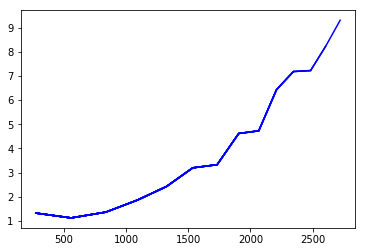

In [5]:
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    d = False
    state = env.reset()
    life = number_lives

    get_init_state(history, state)

    while not done:
        step += 1
        frame += 1
        if render_breakout:
            env.render()

        # Select and perform an action
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)

        
        next_state, reward, done, info = env.step(action + 1)

        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['ale.lives'])

        life = info['ale.lives']
        r = np.clip(reward, -1, 1)

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network
            if(frame % Update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]

        if frame % 50000 == 0:
            print('now time : ', datetime.now())
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.savefig("./save_graph/breakout_dqn.png")

        if done:
            evaluation_reward.append(score)
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 10 episode is bigger than 400
            # stop training
            if np.mean(evaluation_reward) > 10:
                torch.save(agent.policy_net, "./save_model/breakout_dqn")
                sys.exit()

In [6]:
torch.save(agent.policy_net, "./save_model/breakout_dqn")